# 1. Process Nodule Dataset

## Summary

* Load scans and convert to pixels
* Process image by normalizing, then removing everything outside of the lung tissue
* Generate nodule masks by loading nodule coordiates from list3.2 csv file and using the cellmagicwand tool over that coordinate

In [53]:
#pip install h5py

In [64]:
#EDIT HERE##############################

#File paths
metadatapath="/Users/nehashaikh/Documents/DATA_270/LungNoduleDetectionClassification/LIDC/LIDC-IDRI_MetaData.csv"
list32path="/Users/nehashaikh/Documents/DATA_270/LungNoduleDetectionClassification/LIDC/list3.2.csv"
DOIfolderpath='/Users/nehashaikh/Documents/DATA_270/LUNA/LIDC/manifest-1600709154662/LIDC-IDRI/'
datafolder='processeddata'

########################################

import cell_magic_wand as cmw
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

from skimage import measure, morphology
#from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.draw import disk
#Load metadata
meta=pd.read_csv(metadatapath)
meta=meta.drop(meta[meta['Modality']!='CT'].index)
meta=meta.reset_index()
meta1 = meta.head(120)
print(len(meta1))
#Get folder names of CT data for each patient
patients=[DOIfolderpath+meta['Patient Id'][i] for i in range(len(meta1))]
datfolder=[]
for i in range(0,len(meta1)-1):
    for path in os.listdir(patients[i]):
        if os.path.exists(patients[i]+'/'+path+'/'+meta1['Series UID'][i]):
            datfolder.append(patients[i]+'/'+path+'/'+meta1['Series UID'][i])
patients=datfolder

#Load nodules locations
nodulelocations=pd.read_csv(list32path)



120


FileNotFoundError: [Errno 2] No such file or directory: '/Users/nehashaikh/Documents/DATA_270/LUNA/LIDC/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0206'

In [49]:
# Load the scans in given folder path
# code sourced from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s, force=True) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

#convert to ndarray
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True, dilate=False):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures==True:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
    if dilate==True:
        for i in range(binary_image.shape[0]):
            binary_image[i]=morphology.dilation(binary_image[i],np.ones([10,10]))
    return binary_image

In [52]:
#Let's look at one of the patients

first_patient = load_scan(patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

import scipy
# Show some slice in the middle
#data=scipy.ndimage.interpolation.zoom(first_patient_pixels[41],[200,200])
plt.figure()
plt.imshow(first_patient_pixels[42])
plt.annotate('', xy=(317, 367), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
#plt.savefig("images/test.png",dpi=300)
plt.show()



IndexError: list index out of range

In [ ]:
def processimage(img):
    #function sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    #plt.imshow(labels)
    #plt.show()
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    return mask*img

def nodule_coordinates(nodulelocations,meta):
    slices=nodulelocations["slice no."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    xlocs=nodulelocations["x loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    ylocs=nodulelocations["y loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    nodulecoord=[]
    for i in range(len(slices)):
        nodulecoord.append([slices.values[i]-1,xlocs.values[i]-1,ylocs.values[i]-1])
    return nodulecoord

In [ ]:
#Generate and save nodule images for all samples
'''
for i in range(15,len(patients)):
    print(i)
    first_patient = load_scan(patients[i])
    first_patient_pixels = get_pixels_hu(first_patient)
    nodcord=nodule_coordinates(nodulelocations,meta.loc[i])
    for j in range(len(nodcord)):
        #plt.imsave("images/"+meta['Patient Id'].loc[i]+"slice"+str(slice)+".png",first_patient_pixels[slice])
        plt.figure()
        plt.imshow(first_patient_pixels[nodcord[j][0]])
        plt.annotate('', xy=(nodcord[j][1], nodcord[j][2]), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
        plt.savefig("images/"+meta['Patient Id'].loc[i]+"slice"+str(nodcord[j])+".png",dpi=300)
        plt.close()
'''

In [ ]:
noduleimages=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.float32)
nodulemasks=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
nodulemaskscircle=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
index=0
totaltime=50000
start_time=time.time()
elapsed_time=0
nodulemeanhu=[]
nonnodulemeanhu=[]
thresh=-500
for i in range(len(patients)):
    print("Processing patient#",i,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    if len(coord)>0:
        patient=load_scan(patients[i])
        patient_pix=get_pixels_hu(patient)
        radius=nodulelocations["eq. diam."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][i][-4:])]]
        nodulemask=np.ndarray([len(coord),512,512],dtype=np.bool)
        for j,cord in enumerate(coord):
            segmented_mask_fill=segment_lung_mask(patient_pix,True,False)
            if radius.iloc[j]>5:
                #slice nodulecenter-1
                noduleimages[index]=processimage(patient_pix[cord[0]-1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])-1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                rr,cc=circle(int(cord[2]),int(cord[1]),int(radius.iloc[j]))
                imgcircle = np.zeros((512, 512), dtype=np.int16)
                imgcircle[rr,cc]=1
                nodulepixcircle=imgcircle*patient_pix[cord[0]-1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                
                nodulepix=nodulemasks[index]*patient_pix[cord[0]-1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                index+=1
                
                #slice nodulecenter
                noduleimages[index]=processimage(patient_pix[cord[0]])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]]
                nodulepix[nodulepix<thresh]=0
                nodulepixcircle=imgcircle*patient_pix[cord[0]]
                nodulepixcircle[nodulepixcircle<thresh]=0
                
                #get mean nodule HU value

                #get mean non-nodule HU value
                nonnodule=(nodulemasks[index].astype(np.int16)-1)*-1*segmented_mask_fill[cord[0]]*patient_pix[cord[0]]
                nonnodule[nonnodule<thresh]=0
                nonnodulemeanhu.append(np.mean(nonnodule[nonnodule!=0]))
                plt.figure()
                #plt.hist(nodulepix[nodulepix!=0].flatten(),bins=80, alpha=0.5, color='blue')
                plt.hist(nonnodule[nonnodule!=0].flatten(),bins=80, alpha=0.5, color='orange')
                plt.hist(nodulepixcircle[nodulepix!=0].flatten(),bins=80,alpha=0.5, color='green')
                plt.savefig("histplots/"+meta['Patient Id'].loc[i]+"slice"+str(cord)+".png",dpi=300)
                plt.close()
                nodulemeanhu.append(np.mean(nodulepix[nodulepix!=0]))
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
                
                #slice nodulecenter+1
                noduleimages[index]=processimage(patient_pix[cord[0]+1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])+1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]+1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle=imgcircle*patient_pix[cord[0]+1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(i+1)*len(patients)
np.save(datafolder+'/noduleimages.npy',noduleimages)
np.save(datafolder+'/nodulemasks.npy',nodulemasks)
np.save(datafolder+'/nodulemaskscircle.npy',nodulemaskscircle)

Processing patient# 0 ETA: 13.88888888888889 hrs
Processing patient# 1 ETA: 2.636670792367723 hrs
Processing patient# 2 ETA: 3.67324132439163 hrs
Processing patient# 3 ETA: 5.957215151256985 hrs
Processing patient# 4 ETA: 5.327770197590192 hrs
Processing patient# 5 ETA: 5.793750263902877 hrs
Processing patient# 6 ETA: 6.373408978614542 hrs
Processing patient# 7 ETA: 6.239070732442159 hrs
Processing patient# 8 ETA: 6.071023768178291 hrs
Processing patient# 9 ETA: 6.182566953235202 hrs
Processing patient# 10 ETA: 6.841921355532275 hrs
Processing patient# 11 ETA: 8.01078399029645 hrs
Processing patient# 12 ETA: 9.588434534768263 hrs
Processing patient# 13 ETA: 9.397183720331928 hrs
Processing patient# 14 ETA: 8.963372415550172 hrs
Processing patient# 15 ETA: 8.756867530372407 hrs
Processing patient# 16 ETA: 9.19578843102687 hrs
Processing patient# 17 ETA: 9.062609851749894 hrs
Processing patient# 18 ETA: 9.139445660809676 hrs
Processing patient# 19 ETA: 9.095597724126794 hrs
Processing pa

Processing patient# 164 ETA: 6.807470953385763 hrs
Processing patient# 165 ETA: 6.809158936240456 hrs
Processing patient# 166 ETA: 6.7984306099141145 hrs
Processing patient# 167 ETA: 6.784184024521136 hrs
Processing patient# 168 ETA: 6.770676555769548 hrs
Processing patient# 169 ETA: 6.754498656070366 hrs
Processing patient# 170 ETA: 6.798816377894162 hrs
Processing patient# 171 ETA: 6.782449454410732 hrs
Processing patient# 172 ETA: 6.845348693788514 hrs
Processing patient# 173 ETA: 6.86010672359491 hrs
Processing patient# 174 ETA: 6.852058787774081 hrs
Processing patient# 175 ETA: 6.828224685145181 hrs
Processing patient# 176 ETA: 6.831361465594835 hrs
Processing patient# 177 ETA: 6.784694465136123 hrs
Processing patient# 178 ETA: 6.793573079629337 hrs
Processing patient# 179 ETA: 6.951149829779997 hrs
Processing patient# 180 ETA: 7.0948268424868575 hrs
Processing patient# 181 ETA: 7.074187315000648 hrs
Processing patient# 182 ETA: 7.20301468269365 hrs
Processing patient# 183 ETA: 7.

Processing patient# 325 ETA: 7.258254871449105 hrs
Processing patient# 326 ETA: 7.238422929314056 hrs
Processing patient# 327 ETA: 7.219212023332093 hrs
Processing patient# 328 ETA: 7.19886003631119 hrs
Processing patient# 329 ETA: 7.1815327459088625 hrs
Processing patient# 330 ETA: 7.1612511656886415 hrs
Processing patient# 331 ETA: 7.143327732332283 hrs
Processing patient# 332 ETA: 7.1707972318941415 hrs
Processing patient# 333 ETA: 7.149883003957995 hrs
Processing patient# 334 ETA: 7.128551089674612 hrs
Processing patient# 335 ETA: 7.096867567666926 hrs
Processing patient# 336 ETA: 7.085291445913414 hrs
Processing patient# 337 ETA: 7.242506169714709 hrs
Processing patient# 338 ETA: 7.310107571766182 hrs
Processing patient# 339 ETA: 7.2778107113308375 hrs
Processing patient# 340 ETA: 7.2554296232350906 hrs
Processing patient# 341 ETA: 7.26919002610412 hrs
Processing patient# 342 ETA: 7.254288276820851 hrs
Processing patient# 343 ETA: 7.228240308862 hrs
Processing patient# 344 ETA: 7.

Processing patient# 486 ETA: 5.936299187028358 hrs
Processing patient# 487 ETA: 5.925628283148673 hrs
Processing patient# 488 ETA: 5.906098868204026 hrs
Processing patient# 489 ETA: 5.886636600877935 hrs
Processing patient# 490 ETA: 5.868538619247425 hrs
Processing patient# 491 ETA: 5.845474227736724 hrs
Processing patient# 492 ETA: 5.846666473198713 hrs
Processing patient# 493 ETA: 5.829622630678589 hrs
Processing patient# 494 ETA: 5.817484349233311 hrs
Processing patient# 495 ETA: 5.7946319086648 hrs
Processing patient# 496 ETA: 5.7796850161667 hrs
Processing patient# 497 ETA: 5.7652339554888385 hrs
Processing patient# 498 ETA: 5.7425930341403975 hrs
Processing patient# 499 ETA: 5.733039159087289 hrs
Processing patient# 500 ETA: 5.7227418220712085 hrs
Processing patient# 501 ETA: 5.700273002953189 hrs
Processing patient# 502 ETA: 5.6840195046445094 hrs
Processing patient# 503 ETA: 5.668418624070087 hrs
Processing patient# 504 ETA: 5.660538838690235 hrs
Processing patient# 505 ETA: 5.

Processing patient# 647 ETA: 4.042658665439997 hrs
Processing patient# 648 ETA: 4.033742225326504 hrs
Processing patient# 649 ETA: 4.019162230133255 hrs
Processing patient# 650 ETA: 4.01238861427409 hrs
Processing patient# 651 ETA: 3.9969108170756167 hrs
Processing patient# 652 ETA: 3.9832806893338035 hrs
Processing patient# 653 ETA: 3.9680462139809385 hrs
Processing patient# 654 ETA: 3.9510946160816154 hrs
Processing patient# 655 ETA: 3.939004831689813 hrs
Processing patient# 656 ETA: 3.923465130472693 hrs
Processing patient# 657 ETA: 3.9083558130482015 hrs
Processing patient# 658 ETA: 3.8915763210754104 hrs
Processing patient# 659 ETA: 3.88105168922296 hrs
Processing patient# 660 ETA: 3.8643472577763935 hrs
Processing patient# 661 ETA: 3.851362489038885 hrs
Processing patient# 662 ETA: 3.834742926948521 hrs
Processing patient# 663 ETA: 3.8199186803582577 hrs
Processing patient# 664 ETA: 3.813859340481888 hrs
Processing patient# 665 ETA: 3.8172148768776344 hrs
Processing patient# 666 

Processing patient# 807 ETA: 2.3180904248488536 hrs
Processing patient# 808 ETA: 2.316291924637258 hrs
Processing patient# 809 ETA: 2.306327914953264 hrs
Processing patient# 810 ETA: 2.2937364133493388 hrs
Processing patient# 811 ETA: 2.286457296569701 hrs
Processing patient# 812 ETA: 2.2725560346806906 hrs
Processing patient# 813 ETA: 2.2617019531706317 hrs
Processing patient# 814 ETA: 2.251034232953144 hrs
Processing patient# 815 ETA: 2.2417898317603897 hrs
Processing patient# 816 ETA: 2.2294368812746184 hrs
Processing patient# 817 ETA: 2.219648920466718 hrs
Processing patient# 818 ETA: 2.205850871338757 hrs
Processing patient# 819 ETA: 2.195107054755509 hrs
Processing patient# 820 ETA: 2.1879454139882952 hrs
Processing patient# 821 ETA: 2.175421501018146 hrs
Processing patient# 822 ETA: 2.170169224909718 hrs
Processing patient# 823 ETA: 2.157458074163197 hrs
Processing patient# 824 ETA: 2.1476923447520253 hrs
Processing patient# 825 ETA: 2.1348969293151234 hrs
Processing patient# 82

Processing patient# 966 ETA: 0.5782392379871878 hrs
Processing patient# 967 ETA: 0.5664571811793172 hrs
Processing patient# 968 ETA: 0.5550505765623954 hrs
Processing patient# 969 ETA: 0.5433182724472762 hrs
Processing patient# 970 ETA: 0.5316573555100149 hrs
Processing patient# 971 ETA: 0.5205682803516679 hrs
Processing patient# 972 ETA: 0.508727682949094 hrs
Processing patient# 973 ETA: 0.4980411447653205 hrs
Processing patient# 974 ETA: 0.4870250405290608 hrs
Processing patient# 975 ETA: 0.4752110044446757 hrs
Processing patient# 976 ETA: 0.46504625133118277 hrs
Processing patient# 977 ETA: 0.4539306261454577 hrs
Processing patient# 978 ETA: 0.4434611245786639 hrs
Processing patient# 979 ETA: 0.4318696981290325 hrs
Processing patient# 980 ETA: 0.4210811269784063 hrs
Processing patient# 981 ETA: 0.40988899986313804 hrs
Processing patient# 982 ETA: 0.3980974162817256 hrs
Processing patient# 983 ETA: 0.3863963788954627 hrs
Processing patient# 984 ETA: 0.37465066828903826 hrs
Processing

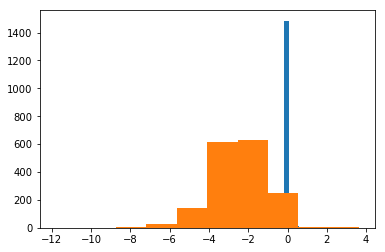

In [ ]:
#Exploratory analysis
plt.hist(nodulemeanhu, bins=20)
plt.hist(nonnodulemeanhu)
plt.show()

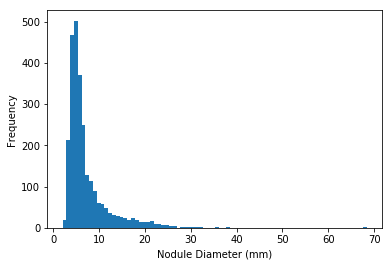

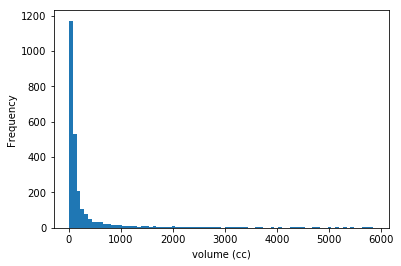

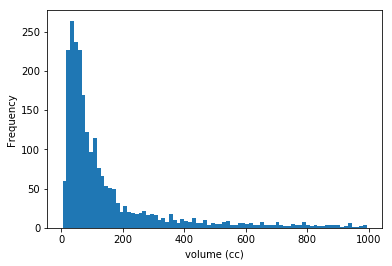

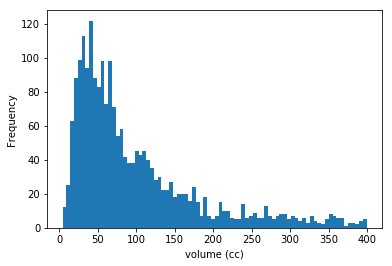

In [ ]:
plt.hist(nodulelocations['eq. diam.'], bins=80)
plt.xlabel("Nodule Diameter (mm)")
plt.ylabel("Frequency")
plt.show()

plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<6000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<1000], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()
plt.hist(nodulelocations['volume'].loc[nodulelocations['volume']<400], bins=80)
plt.xlabel("volume (cc)")
plt.ylabel("Frequency")
plt.show()

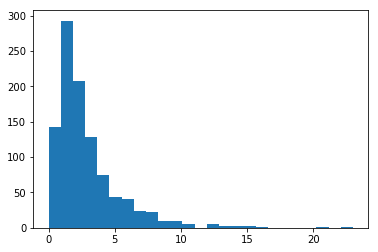

In [ ]:
nodcount=[]
for i in range(len(patients)):
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    nodcount.append(len(coord))
    
plt.hist(nodcount, bins=25)
plt.xlabel("Number of Nodules per Patient")
plt.show()